In [2]:
### L4 Roots of eqns
'''
- Identify nonlinear eqns
- Solve these eqns using the scipy.optimize functions bisect and newton
- Explain the algorithms that underlie the Bisection, Newton and Secant method
- Explain why these methods are considered iterative and approximative and how this relates to tolerances
- Demonstrate several types of convergence errors
'''

import numpy as np
import matplotlib.pyplot as plt

# scipy's optimization
import scipy as sci

In [3]:
### Nonlinear equations
# linear eqn eg. f(x) = 0  where f(x):= a + kx
# analytical --> can write down solution as something we can readily evaluate (eg MM4 PDEs)

# Nonlinear problem without trivial soln: x = tan(x)
# f(x) approx= 0 where f(x):= x - tan(x) (= tan(x) - x)
# soln to f(x) = 0 is called a root

In [4]:
### Picard's method of successive approximations (or fixed point iteration)
# form of x = g(x)
# x that satisfies --> fixed point of function g [x = g(x) = g(g(x) = g(g(g(x)))]
# also a root (satisfies 0 = f(x) := x - g(x)) but not all roots are fixed points

# eg g(x) := x^2 - 3x + 4 --> fixed point 2 (g(2) = 2)
# eg g(x) = x + 1 has no fixed points

### Visual inspection
" plot y = g(x) --> fixed points are where curve intersects with the line y=x "

' plot y = g(x) --> fixed points are where curve intersects with the line y=x '

In [5]:
### Method of successive approximations (Picard iteration)
# guess x --> plug in RHS g(.) --> new x used for updated guess
# x^(k+1) = g (x ^ k ), start from x^ (0)
# x ^ (k+1) - x^k = g (x^k) - x^k so dx below tolerance --> x=g(x) for same tolerance
# converges to x = g(x) 

# cobweb plot --> sets x value into 'y' value (g(x)) for consecutive iterations


## Ex 4.1 Implementing successive approximation for x = e ^ (-x)
def picard(f, x, atol=1.0e-6):
    """ Function implementing Picard's method
    f here is the function g(.) described in the lecture and we are solving x = g(x)
    x is an initial guess
    atol is a user-defined (absolute) error tolerance
    """
    # record number of function evaluations so we can later compare methods
    fevals = 0
    # initialise the previous x simply so that while loop argument is initially true
    x_prev = x + 2*atol
    while abs(x - x_prev) > atol:
        x_prev = x
        x = f(x_prev) # one function evaluation
        fevals += 1

        print('Current iteration solution: ',x, x_prev)
    print('\nPicard used', fevals, 'function evaluations')
    return x



def g(x):
    return np.exp(-x)


print('\nSolution from Picard: ', picard(g, 0.9, atol=1.0e-7))  # 0.9 is our initial guess


# let's check our answer against a SciPy function: sop.newton.
def f(x):
    return x - np.exp(-x)

print('\nCheck this against the solution from SciPy: sop.newton(f, 0.9)=', sci.optimize.newton(f, 0.9))

# NB. if we tighten up the atol toelrance in our call to picard the answer gets closer to SciPy 
# but of course takes more iterations.

Current iteration solution:  0.4065696597405991 0.9
Current iteration solution:  0.6659307054401221 0.4065696597405991
Current iteration solution:  0.5137951132027094 0.6659307054401221
Current iteration solution:  0.5982209490817094 0.5137951132027094
Current iteration solution:  0.5497888689549504 0.5982209490817094
Current iteration solution:  0.5770716352569477 0.5497888689549504
Current iteration solution:  0.5615403562006408 0.5770716352569477
Current iteration solution:  0.570329875730725 0.5615403562006408
Current iteration solution:  0.5653389163484923 0.570329875730725
Current iteration solution:  0.5681675528504282 0.5653389163484923
Current iteration solution:  0.566562684236262 0.5681675528504282
Current iteration solution:  0.5674726729169729 0.566562684236262
Current iteration solution:  0.5669565140929677 0.5674726729169729
Current iteration solution:  0.5672492292377977 0.5669565140929677
Current iteration solution:  0.5670832110967041 0.5672492292377977
Current iterat

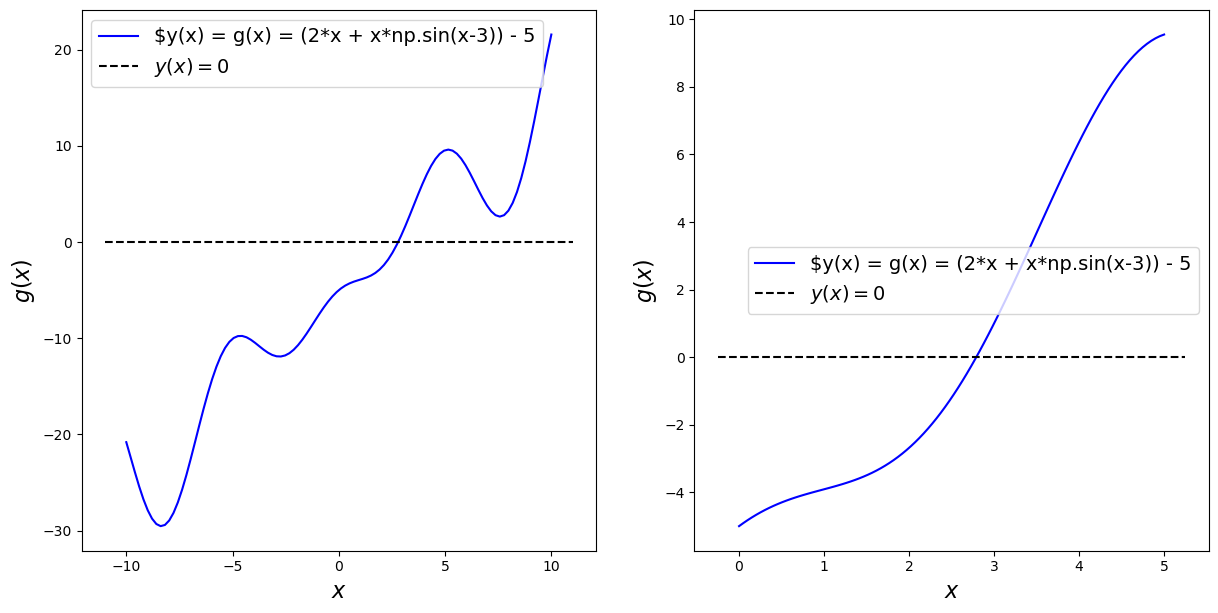

In [6]:
## Ex 4.2 Visual inspection for initial guess 2x + xsin(x - 3) = 5 for - 10 < x < 10

# for this problem we can define f as 5 - (2*x + x*np.sin(x-3)), or (2*x + x*np.sin(x-3)) - 5.
# it makes no difference to the root-finding, just the plots
" plot g(x) = 0 as we are finding ROOT"
def f(x):
    return (2*x + x*np.sin(x-3)) - 5

# plot the function over the whole interval being considered
x = np.linspace(-10,10,100)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
fig.tight_layout(w_pad=4, h_pad=4)

ax1.plot(x, f(x), 'b', label='$y(x) = g(x) = (2*x + x*np.sin(x-3)) - 5')
xlim = ax1.get_xlim()
ax1.plot([xlim[0], xlim[1]], [0., 0.], 'k--', label='$y(x)=0$')

ax1.legend(loc='best', fontsize=14)
ax1.set_xlabel('$x$', fontsize=16)
ax1.set_ylabel('$g(x)$', fontsize=16)

# now plot the function over a smaller interval
x = np.linspace(0, 5, 100)

ax2.plot(x, f(x), 'b', label='$y(x) = g(x) = (2*x + x*np.sin(x-3)) - 5')
xlim = ax2.get_xlim()
ax2.plot([xlim[0], xlim[1]], [0., 0.], 'k--', label='$y(x)=0$')

ax2.legend(loc='best', fontsize=14)
ax2.set_xlabel('$x$', fontsize=16)
ax2.set_ylabel('$g(x)$', fontsize=16)
ax2.legend(loc='best', fontsize=14)

In [7]:
### Root bracketing algorithm (incremental search)
# Visual inspectio to identify root and narrow down where root can be found
# identifies smaller bracket around root by deteching a change in sign of function g(x)

## Ex 4.3 using subinterval from Ex 4.2 to construct root bracketing algorithm
def f(x):
    return 2*x + x*np.sin(x-3) - 5


def root_bracketing(f, a, b, dx):
    """ Function to perform root bracketing on the function f(.)
    between a and b, with fixed interval size dx.
    Returns the bracket of size dx that contains the root.
    """ 
    # The sign function returns:  -1 if x < 0;  0 if x==0;  1 if x > 0.
    sign = np.sign(f(a))
    while sign == np.sign(f(a)):
        a += dx
        if a >= b:
            raise RuntimeError('no root within [a,b]')
    return (a-dx, a)


a = 0.
b = 5.
dx = 0.1
# print out the output from our root_bracketing function
print('Bracket = ', root_bracketing(f, a, b, dx))


Bracket =  (2.700000000000001, 2.800000000000001)


In [8]:
### Bisection Method
# further close in--> gradually desc dx by 1/2 AND change direction depending on sign of f(x1)f(x2)

# if root in interval --> f(x1)f(x2) < 0
# compute midpoint and calculate f(x2)f(x3)
# if f(x2) f(x3) < 0 --> root in [x2, x3] hence replace x1 with x3
# if f(x2) f(x3) > 0 --> root in [x1, x3] hence replace x2 with x3
# new interval is 1/2 size of original interval --> repeat till convergence tolerance

In [9]:
## Ex 4.4 implementing bisection algorithm for Ex 4.3
def bisection(func, a, b, atol=1.0E-6, nmax=100):
    n = 0
    x1 = a
    x2 = b
    while n <= nmax:

        while abs(a-b) > atol:
            x3 = (x1 + x2) / 2
            f1 = func(x1)
            f2 = func(x2)
            f3 = func(x3)

            "very important to return x3 here"
            if (x2 - x1) / 2 < atol:
                return x3

            if f2*f3 < 0.0:
                x1 = x3
                f1 = f3
            else:
                x2 = x3
                f2 = f3

            n += 1
        
    raise RuntimeError('no root found within [a,b]')

def f(x):
    return 2*x + x*np.sin(x-3) - 5

a = 2.7
b = 2.8

print(bisection(f, a, b))
print(sci.optimize.bisect(f, a, b))

2.79035415649414
2.7903546180677945


In [10]:
## Newton Method
# uses f'(x) to find intersection of tangent at x with zero
# assumes f'(x) is available --> Quasi-Newton uses first principles approximation
    # convergence isnt as good but closer to quadratic than linear
# Taylor series --> set f(x(i + 1)) = 0 and assume x(i + 1) is close to xi
# Error --> quadratic convergence

def f(x):
    return x - np.exp(-x)

def dfdx(x):
    return 1 + np.exp(-x)

x0 = -1. # initial guess
print(sci.optimize.newton(f, x0, dfdx))

0.567143290409784


In [11]:
## Ex 4.5 use Ex 4.2 sub interval as initital guess xo and implement Newton Method

def newton(f, x0, dfdx, atol=1.0e-6, maxiter=100):
    """ Function to implement the Newton-Raphson method
    f is the function we are trying to find a root of
    and dfdx is another function which return the derivative of f
    """
    x_n = [x0]
    fevals = 0
    while True:
        " x[-1] works because list"
        " REMEMBER to input x[-1] in f and dfdx"
        x = x_n[-1] - f(x_n[-1])/ dfdx(x_n[-1])
        x_n.append(x)
        fevals += 1
        if abs(x_n[-1] - x_n[-2]) < atol:
            print('Newton (analytical derivative) used', fevals, 'function evaluations')
            return x_n[-1]
        if fevals >= maxiter:
            break


def f(x):
    return (2*x + x*np.sin(x-3)) - 5

def dfdx(x):
    "manually compute and input"
    return 2 - np.sin(3-x) + x*np.cos(3-x)

x0 = 0. # initial guess somwhere in interval
print(newton(f, x0, dfdx))
print(sci.optimize.newton(f, x0, dfdx))

Newton (analytical derivative) used 5 function evaluations
2.7903546180673837
2.7903546180673837


In [12]:
## Ex 4.6 extend Ex 4.5 to compute f'(x) using finite difference approx

def quasi_newton(f, x0, dx=1.0E-7, atol=1.0E-6, maxiter=100):
    """ Function to implement quasi-newton
    f is the function we are trying to find a root of
    """
    x_n = [x0]
    fevals = 0

    dfdx_n = []
    while True:
        dfdx = (f(x_n[-1] + dx) - f(x_n[-1])) / dx
        x = x_n[-1] - f(x_n[-1])/ dfdx
        x_n.append(x)
        fevals += 1

        if abs(x_n[-1] - x_n[-2]) < atol:
            print('Newton (analytical derivative) used', fevals, 'function evaluations')
            return x_n[-1]
        if fevals >= maxiter:
            break

    
def f(x):
    return (2*x + x*np.sin(x-3)) - 5

x0 = 0.
print(quasi_newton(f, x0))
print(sci.optimize.newton(f, x0))


Newton (analytical derivative) used 5 function evaluations
2.7903546180673837
2.7903546180673837


In [15]:
## Secant Method
# replaces local derivitive in newton by difference approximation based on two consecutive xn
# f'(x) approx= (f(xn)-f(xn-1)) / (xn - xn-1) --> doesnt require derivative + only takes 2 points

## Ex 4.7 use Ex 4.2 subinterval to find x0 = a and x1 = a + 0.1 
def secant(f, x0, x1, atol=1.0E-6):
    """ Function to implement the secant method
    x0 and x1 are the two required guesses
    f is the function we are trying to find a root of
    """
    x_n = [x0, x1]
    while True:
        x = x_n[-1] - f(x_n[-1])*((x_n[-1]-x_n[-2])/(f(x_n[-1])-f(x_n[-2])))
        x_n.append(x)
        if abs(x_n[-1] - x_n[-2]) < atol:
            return x_n[-1]

def f(x):
    return 2*x + x*np.sin(x-3) - 5

x0 = 0.
x1 = x0 + 0.1
print(secant(f, x0, x1))
print(sci.optimize.newton(f, x0))

2.7903546180673446
2.7903546180673837


In [ ]:
### Potential convergence issues
# depends on starting guess
    # multiple roots in vicinity --> converges to one but this "one" could 
        #change with sligth changes to intital guess
    # nearly singular/ numerical overflow --> local gradient guess at x^k is near zero
        # gradient approx is beyond representable range --> jumps to distance away and converges to wrong root
    # Oscillagtions --> algorithm bounces back and forth